# Predict a building's Energy Star 
### Part 2- Modelling

### Imports 

We will use the standard data science and machine learning libraries in this project. 

In [39]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data

First let's read in the formatted data from the previous notebook. 

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


As a reminder, here is what the formatted data looks like. In the first notebook, we engineered a number features by taking the natural log of the variables, included two categorical variables, and selected a subset of features by removing highly collinear features. 

In [3]:
train_features.head(12)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Library,...,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,NaN,NaN,NaN,NaN,6.088818,4.599253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,40.835496,-73.887745,3.0,161.0,5.384036,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,40.663206,-73.949469,9.0,329.0,5.017280,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,40.622968,-74.078742,1.0,27.0,6.510853,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,40.782421,-73.972622,7.0,165.0,6.123589,3.355153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,40.725136,-74.004438,2.0,37.0,5.516649,1.568616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,40.637833,-73.973045,12.0,490.0,5.426271,4.206780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,40.776035,-73.964418,8.0,142.0,6.067036,3.425239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137

The `score` column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supposed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one! 

Here's the distribution of the Energy Star Score.

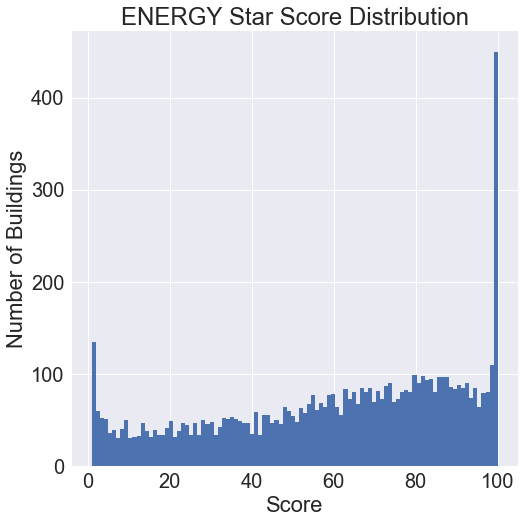

In [4]:
figsize(8, 8)

# Histogram of the Energy Star Score
plt.hist(train_labels['score'].dropna(), bins = 100);
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
plt.title('ENERGY Star Score Distribution');

# Evaluating and Comparing Machine Learning Models

In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning). 

We are comparing models using the __mean absolute error__. A baseline model that guessed the median value of the score was off by an __average of 25 points__. 

## Imputing Missing Values

Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in these missing values, a process known as [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)). There are a number of methods for imputation but here we will use the relatively simple method of replacing missing values with the median of the column. ([Here is a more thorough discussion on imputing missing values](http://www.stat.columbia.edu/~gelman/arm/missing.pdf))

In [5]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [7]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


After imputation, all of the features are real-valued. For more sophisticated methods of imputation (although median values usually works well) check out [this article](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146)

### Scaling Features

The final step to take before we can build our models is to [scale the features](https://en.wikipedia.org/wiki/Feature_scaling). This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. [Linear Regression and Random Forest do not require feature scaling](https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data), but other methods, such as support vector machines and k nearest neighbors, do require it because they take into account the Euclidean distance between observations. For this reason, it is a best practice to scale features when we are comparing multiple algorithms. 

There are two ways to [scale features](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html):

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

Here is a good article about [normalization and standardization](https://machinelearningmastery.com/normalize-standardize-machine-learning-data-weka/).

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [8]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to Evaluate

We will compare five different machine learning models using the great [Scikit-Learn library](http://scikit-learn.org/stable/):

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

To compare the models, we are going to be mostly using the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, and then we can select the best performing model for further optimization using hyperparameter tuning.

In [10]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4651


/Users/adhiman/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [12]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 10.9337


In [13]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 10.0147


In [14]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 10.0132


In [15]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 13.0131


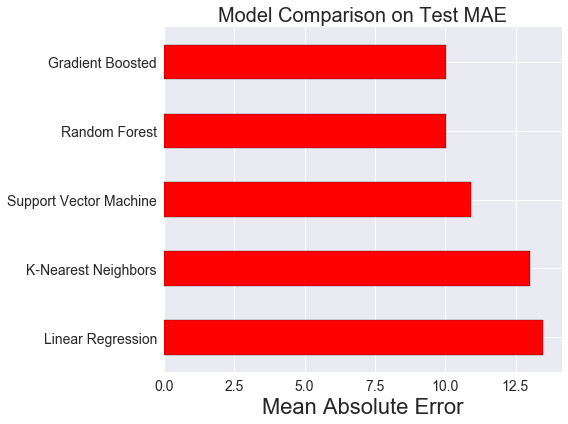

In [23]:
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)
plt.legend('')
plt.tight_layout();

From here, I am going to concentrate on optimizing the best model using hyperparamter tuning. Given the results here, I will concentrate on using the `GradientBoostingRegressor`. 

# Model Optimization 

In machine learning, optimizing a model means finding the best set of hyperparameters for a particular problem. 

## Hyperparameters

[Tuning the model hyperparameters](http://scikit-learn.org/stable/modules/grid_search.html) controls the balance of under vs over fitting in a model. We can try to correct for under-fitting by making a more complex model, such as using more trees in a random forest or more layers in a deep neural network. A model that underfits has high bias, and occurs when our model does not have enough capacity (degrees of freedom) to learn the relationship between the features and the target. We can try to correct for overfitting by limiting the complexity of the model and applying regularization. This might mean decreasing the degree of a polynomial regression, or adding dropout layers to a deep neural network. A model that overfits has high variance and in effect has memorized the training set. Both underfitting and overfitting lead to poor generalization performance on the test set. 

The problem with choosing the hyperparameters is that no set will work best across all problems. Therefore, for every new dataset, we have to find the best settings. This can be a time-consuming process, but luckily there are several options for performing this procedure in Scikit-Learn. Even better, new libraries, such as [TPOT](https://epistasislab.github.io/tpot/) by epistasis labs, is aiming to do this process automatically for you! For now, we will stick to doing this manually (sort of) in Scikit-Learn, but stay tuned for an article on automatic model selection! 

## Hyperparameter Tuning with Random Search and Cross Validation

We can choose the best hyperparameters for a model through random search and cross validation. 

In [24]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In the code below, we create the Randomized Search Object passing in the following parameters:

* `estimator`: the model
* `param_distributions`: the distribution of parameters we defined
* `cv` the number of folds to use for k-fold cross validation
* `n_iter`: the number of different combinations to try
* `scoring`: which metric to use when evaluating candidates
* `n_jobs`: number of cores to run in parallel (-1 will use all available)
* `verbose`: how much information to display (1 displays a limited amount) 
* `return_train_score`: return the training score for each cross-validation fold
* `random_state`: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one. 

In [25]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [26]:
%%time
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


CPU times: user 10.7 s, sys: 301 ms, total: 11 s
Wall time: 15min 3s


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize. Therefore, a better score will be closer to 0. We can get the results of the randomized search into a dataframe, and sort the values by performance.

In [27]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
12,21.856699,0.453608,0.029032,0.002364,500,6,6,None,5,lad,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.859381,-8.773966,-9.325139,-9.036779,-8.998761,0.210901,1,-7.027368,-6.837958,-6.869084,-6.840749,-6.893790,0.078077
3,23.586591,0.771180,0.035564,0.006835,500,6,8,None,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.868788,-8.904791,-9.315304,-9.075321,-9.041004,0.176509,2,-4.482073,-4.326121,-4.823009,-4.229809,-4.465253,0.225313
9,12.309776,0.190722,0.022591,0.004532,500,4,2,auto,3,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.134318,-9.042461,-9.441179,-9.152240,-9.192518,0.149456,3,-7.007604,-7.088986,-6.913108,-6.940327,-6.987506,0.067939
0,3.719713,0.051915,0.009181,0.001679,100,2,6,auto,5,ls,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.101610,-9.026912,-9.456259,-9.201033,-9.196413,0.162211,4,-7.302003,-7.312645,-7.173397,-7.386171,-7.293554,0.076569
7,10.424583,0.237672,0.019565,0.000689,500,4,6,auto,3,ls,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.146159,-9.199358,-9.699696,-9.357220,-9.350555,0.215966,5,-7.089709,-7.103749,-7.021418,-7.080088,-7.073741,0.031358
10,101.891827,2.877972,0.118077,0.010391,1100,10,6,None,10,huber,"{'n_estimators': 1100, 'min_samples_split': 10...",-9.261256,-9.243867,-9.528538,-9.473096,-9.376652,0.125816,6,-0.378166,-0.459465,-0.393491,-0.370483,-0.400401,0.035092
19,30.444557,0.532153,0.049195,0.005448,1100,6,2,auto,3,lad,"{'n_estimators': 1100, 'min_samples_split': 6,...",-9.379335,-9.382576,-9.473980,-9.290880,-9.381693,0.064740,7,-8.311796,-8.658903,-7.820534,-8.017995,-8.202307,0.316303
2,70.335977,2.567601,0.083129,0.018528,500,4,2,auto,10,huber,"{'n_estimators': 500, 'min_samples_split': 4, ...",-9.385744,-9.288317,-9.572674,-9.429825,-9.419115,0.102366,8,-0.164859,-0.193613,-0.164415,-0.141062,-0.165987,0.018629
16,39.470272,0.934748,0.067222,0.011553,1500,4,6,None,3,ls,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.246573,-9.317156,-9.798950,-9.424668,-9.446787,0.212942,9,-4.821677,-4.876202,-4.776650,-4.729506,-4.801009,0.054284
21,7.326262,0.404379,0.029943,0.000968,500,6,4,log2,5,huber,"{'n_estimators': 500, 'min_samples_split': 6, ...",-9.393840,-9.289175,-9.750806,-9.407503,-9.460295,0.173829,10,-5.684121,-5.742441,-5.571781,-5.666476,-5.666205,0.061337


In [28]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Rather than evaluating all of these settings again, I will focus on a single one, the number of trees in the forest (`n_estimators`). By varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, we would expect to see a significant affect on the amount of under vs overfitting.

In [29]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 5,
                                  min_samples_leaf = 6,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [30]:
%%time
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished


CPU times: user 16.5 s, sys: 261 ms, total: 16.7 s
Wall time: 5min 46s


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

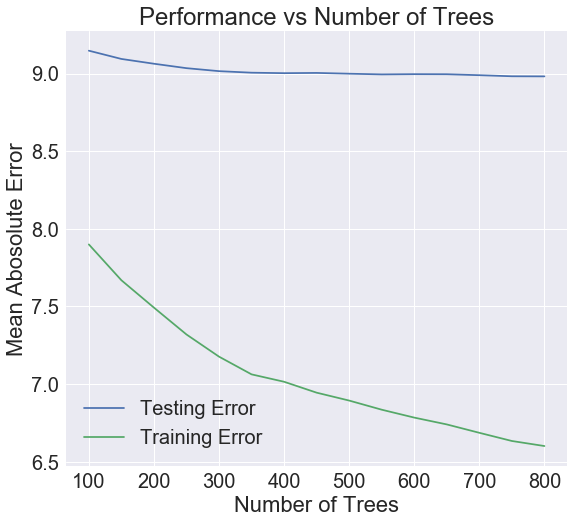

In [40]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [32]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,35.597751,0.752076,0.035664,0.004696,800,{'n_estimators': 800},-8.825018,-8.757257,-9.297520,-9.046451,-8.981504,0.211453,1,-6.739448,-6.648109,-6.486269,-6.530287,-6.601028,0.099437
13,33.876809,1.039307,0.045848,0.008303,750,{'n_estimators': 750},-8.830294,-8.750657,-9.299357,-9.048696,-8.982193,0.213125,2,-6.772908,-6.660453,-6.520818,-6.579989,-6.633542,0.094501
12,33.953599,0.960626,0.046969,0.006421,700,{'n_estimators': 700},-8.835777,-8.754819,-9.313318,-9.052721,-8.989100,0.216536,3,-6.812928,-6.695770,-6.611240,-6.624919,-6.686214,0.079884
9,29.550928,0.719095,0.033206,0.002663,550,{'n_estimators': 550},-8.853451,-8.755897,-9.325442,-9.041991,-8.994138,0.217136,4,-7.003413,-6.781878,-6.809121,-6.745712,-6.835031,0.099783
11,30.429087,0.687990,0.039745,0.002721,650,{'n_estimators': 650},-8.850857,-8.754361,-9.325111,-9.051181,-8.995319,0.218405,5,-6.864375,-6.721452,-6.708191,-6.666758,-6.740194,0.074480


From this plot, it's pretty clear that our model is [overfitting](https://elitedatascience.com/overfitting-in-machine-learning)! The training error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize to the test data as well. Moveover, as the number of trees increases, the amount of overfitting increases. Both the test and training error decrease as the number of trees increase but the training error decreases more rapidly. 

Based on the cross validation results, the best model using 800 trees and achieves a cross validation error under 9. This indicates that the average cross-validation estimate of the Energy Star Score is within 9 points of the true answer! 

# Evaluate Final Model on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world. 

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set. 

In [34]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [35]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

1.03 s ± 73.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [36]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

14.3 s ± 136 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [37]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 10.0118.
Final model performance on the test set:   MAE = 9.0446.


The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time (it's about 12 times slower on my machine). Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation. Here, the increase in run time is not an impediment, because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with. 

To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set. 

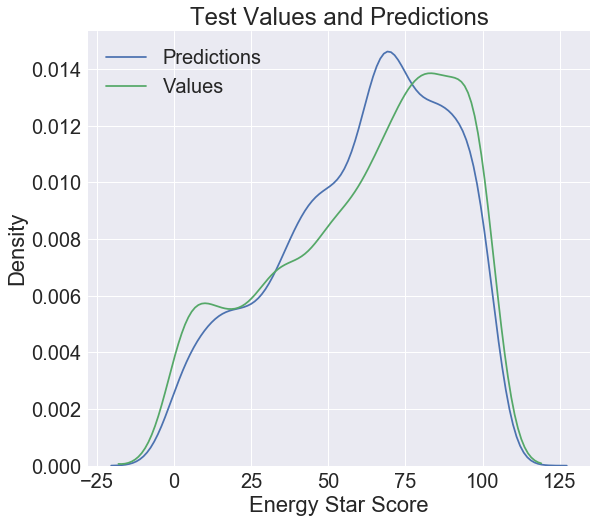

In [41]:
figsize(8, 8)

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median. 

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low). 

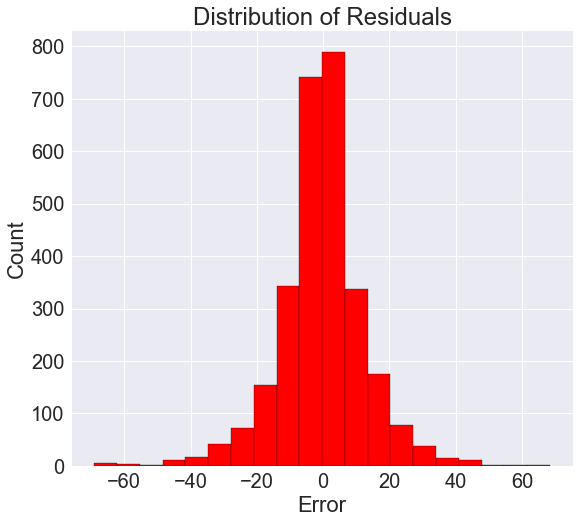

In [42]:
figsize = (6, 6)

# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value. 